# Hypothesis testing with toys

- Invariant mass measurement dataset
- The theoretical model is described by a sum of a resonant and non-resonant amplitude
\begin{equation}
\left|\langle<f|i>\right|^2 = \left| 1 + \frac{a e^{i\theta}}{ (m^2-m_0^2)-i m_0\Gamma}\right|^2
\end{equation}
where $i$ ($f$) is the initial (final) state, $a$ ($\theta$) is the relative magnitude (phase) of the resonant amplitude with respect to the non-resonant, $m_0$ ($\Gamma$) is the mass (width) of the resonance

In [1]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

#### Python

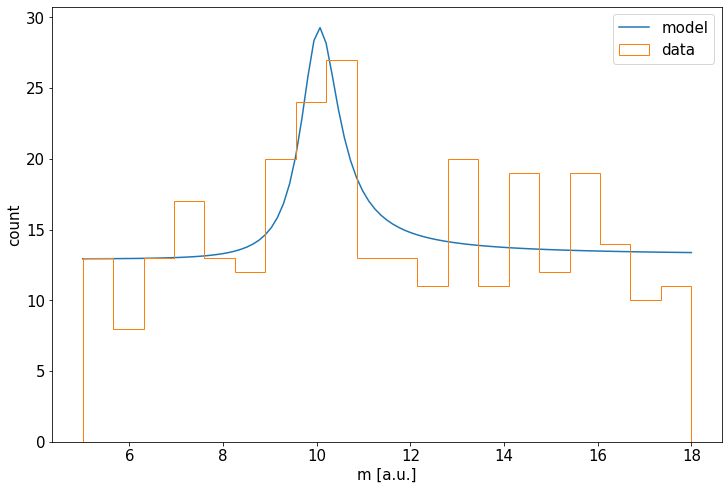

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simpson
from scipy.stats import chi2,norm
from scipy.optimize import minimize
np.random.seed(276884)
#np.random.seed(10)

def model(x,pars):
    a = pars[0]
    theta = pars[1]
    m0 = 10
    gamma = 1
    xint = np.linspace(5,18,10001)
    val_model = lambda x: np.abs(1+a*np.exp(1j*theta)/((x**2-(m0)**2)+1j*m0*gamma))**2
    if (type(a) is not np.ndarray) and type(theta) is not np.ndarray:
        integral = simpson(val_model(xint),xint)
        return val_model(x)/integral
    else:
        a = a.reshape(-1,1)
        theta = theta.reshape(-1,1)
        integral = simpson(val_model(xint),xint,axis=1).reshape(-1,1)
        return val_model(x)/integral    
    #return 1+(np.power(a,2)+2*a*np.sin(theta)*m0*gamma+2*a*(np.power(x,2)-np.power(m0,2))*np.cos(theta))/( np.power(np.power(x,2)-np.power(m0,2),2)+np.power(m0*gamma,2) )
    
def generate_data(a,theta):
    x = np.random.uniform(5,18,1000000)
    y = model(x,[a,theta])
    return x[np.random.uniform(0,np.max(y),1000000)<y][:ndata]

ndata = 300

thetaval = np.pi/2.-0.3
aval = 5
x = np.linspace(5,18,101)
ymodel = model(x,[aval,thetaval])

data = generate_data(aval,thetaval)
len(data)
nbins = 20
plt.plot(x,ymodel*ndata*(x.max()-x.min())/nbins,label='model')
plt.hist(data,bins=np.linspace(x.min(),x.max(),nbins+1),histtype='step',label='data')
plt.xlabel('m [a.u.]')
plt.ylabel('count')
plt.legend(loc='best')

#### ROOT - RooFit

Welcome to JupyROOT 6.26/10

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)


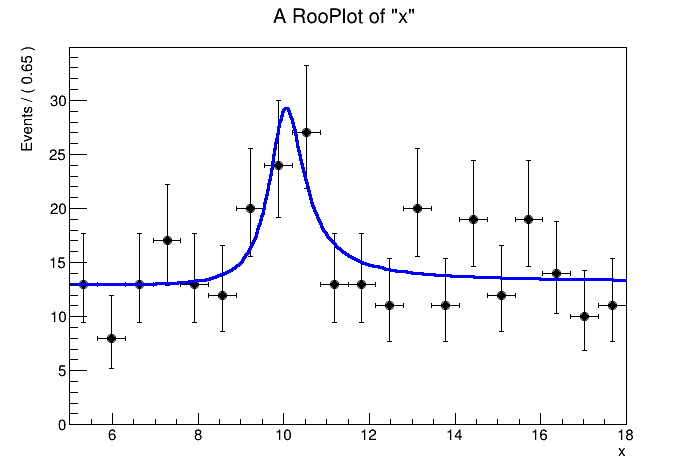

In [3]:
import ROOT
from math import pi
from optparse import OptionParser

ws = ROOT.RooWorkspace()
a = ws.factory('a[%f,0,20]'%aval)
m0 = ws.factory('m0[10]')
gamma = ws.factory('gamma[1]')
theta = ws.factory('theta[%f,%f,%f]'%(thetaval,-pi,pi))
x = ws.factory('x[5,18]')
pdf = ws.factory('GenericPdf::pdf("1+(a^2+2*a*sin(theta)*m0*gamma+2*a*(pow(x,2)-pow(m0,2))*cos(theta))/( pow(pow(x,2)-pow(m0,2),2)+pow(m0*gamma,2))",{x,a,theta,m0,gamma})')

theta.setVal(thetaval)
a.setVal(aval)
c = ROOT.TCanvas()
frame = x.frame()

# generate the dataset from RooFit
#ndata = 300
#roodata = pdf.generate(ROOT.RooArgSet(x),ndata)
# we take the same dataset generated in numpy
roodata = ROOT.RooDataSet('data','data',ROOT.RooArgSet(x))
for xval in data:
    x.setVal(xval)
    roodata.add(ROOT.RooArgSet(x))
nbins=20
roodata.plotOn(frame,ROOT.RooFit.Binning(nbins))
pdf.plotOn(frame)
frame.Draw()
c.Draw()

## Fit the model to data

- fit the model to data with a maximum likelihood fit

#### Python

      fun: 762.3753843371354
 hess_inv: array([[ 2.07687966, -0.00876584],
       [-0.00876584,  0.08583185]])
      jac: array([-7.62939453e-06,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([5.02649396, 1.31897391])


Text(0, 0.5, 'count')

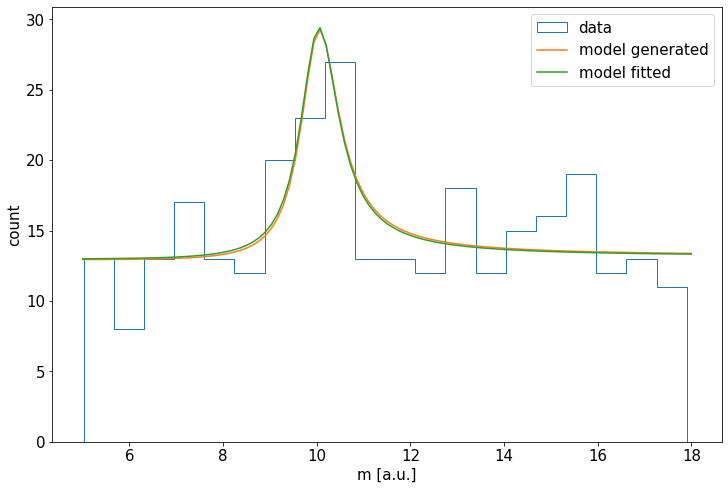

In [4]:
def nll(data,model,pars):
    log = np.log(model(data,pars))
    if len(log.shape)==1: return -np.sum(np.log(model(data,pars)))
    else: return -np.sum(np.log(model(data,pars)),axis=1)

fit_result = minimize(lambda pars: nll(data,model,pars),x0=[aval,thetaval])
print(fit_result)
nbins = 20
x = np.linspace(5,18,101)
plt.hist(data,histtype='step',bins=nbins,label='data')
plt.plot(x,model(x,pars=[aval,thetaval])*ndata*(x.max()-x.min())/nbins,label='model generated')
plt.plot(x,model(x,pars=fit_result.x)*ndata*(x.max()-x.min())/nbins,label='model fitted')
plt.legend(loc='best')
plt.xlabel('m [a.u.]')
plt.ylabel('count')

#### ROOT - RooFit

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minimization -- createConstraintTerm: caching constraint set under name CACHE_CONSTR_OF_PDF_pdf_FOR_OBS_x with 0 entries
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a            5.00000e+00  2.00000e+00    0.00000e+00  2.00000e+01
     2 theta        1.27080e+00  6.28319e-01   -3.14159e+00  3.14159e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: T

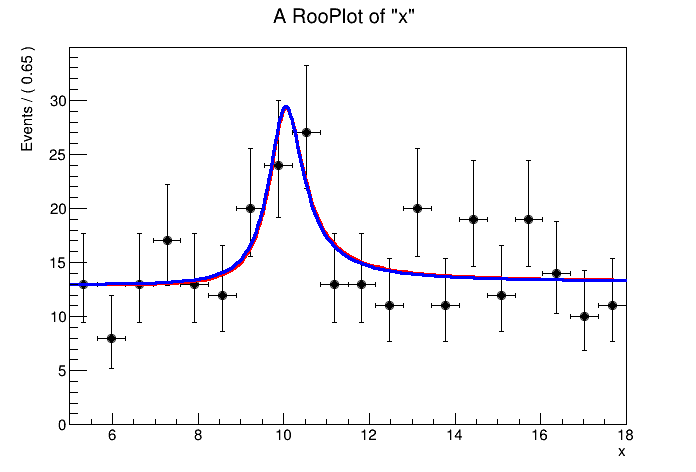

In [5]:
c = ROOT.TCanvas()
frame = ws.var('x').frame()
roodata.plotOn(frame,ROOT.RooFit.Binning(nbins))
ws.var('a').setVal(aval)
ws.var('theta').setVal(thetaval)
pdf.plotOn(frame,ROOT.RooFit.LineColor(ROOT.kRed))
roo_fitresult = pdf.fitTo(roodata,ROOT.RooFit.Save(True))
pdf.plotOn(frame)
frame.Draw()
c.Draw()

## Generate toys to test null hypothesis

- define the test statistic
\begin{equation}
t = -2\log\frac{\mathcal{L}(H_0)}{\mathcal{L}(H_1)} = -2\log\frac{\mathcal{L}(a=0)}{\mathcal{L}(\hat{a},\hat{\theta})}
\end{equation}
where $H_0$ and $H_1$ are the null and alternative hypothesis, $\hat{a}$ and $\hat{\theta}$ represents the best values for $a$ and $\theta$ obtained from the fit to data when both are left floating
- What is the expected test statistic distribution in the null hypothesis if in this case the model depends on just one parameter (for $a=0$, model independent of $\theta$)? How many dof?

#### Python

t_obs = 14.218846
p-value = 0.001000
significance = 3.090232


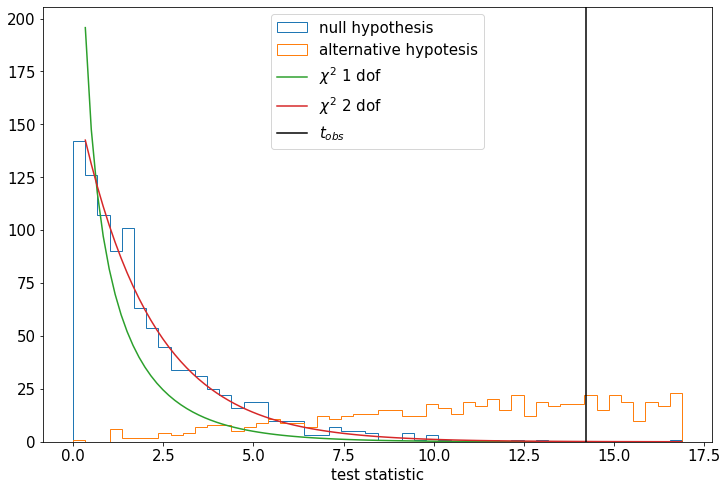

In [6]:
ntoys = 1000
t_null = []
t_alt = []
t_obs = -2*( fit_result.fun - nll(data,model,pars=[0,0]))
for i in range(ntoys):
    toy_data_bkg = generate_data(a=0,theta=0)
    result_bkg = minimize(lambda pars: nll(toy_data_bkg,model,pars),x0=[0,0])
    t_null.append( -2*(result_bkg.fun-nll(toy_data_bkg,model,pars=[0,0])) )
    toy_data_sig = generate_data(a=aval,theta=thetaval)
    result_sig = minimize(lambda pars: nll(toy_data_sig,model,pars),x0=[aval,thetaval])
    t_alt.append( -2*(result_sig.fun-nll(toy_data_sig,model,pars=[0,0])) )

t_null = np.array(t_null)
nbins = 50
_,bins,_=plt.hist(t_null,bins=nbins,histtype='step',label='null hypothesis')
_=plt.hist(t_alt,bins=bins,histtype='step',label='alternative hypotesis')
x = np.linspace(bins[1:].min(),bins.max(),101)
plt.xlabel('test statistic')
plt.plot(x,chi2(1).pdf(x)*ntoys*(bins.max()-bins.min())/nbins,label='$\chi^2$ 1 dof')
plt.plot(x,chi2(2).pdf(x)*ntoys*(bins.max()-bins.min())/nbins,label='$\chi^2$ 2 dof')
plt.axvline(t_obs,color='black',label='$t_{obs}$')
plt.legend(loc='best')
pvalue = len(t_null[t_null>=t_obs])/len(t_null)
print('t_obs = %f'%t_obs)
print('p-value = %f'%pvalue)
print('significance = %f'%(norm.ppf(1-pvalue)))

#### ROOT - RooStats


=== Using the following for bkg model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (a,theta)
PDF:                     RooGenericPdf::pdf[ actualVars=(x,a,theta,m0,gamma) formula="1+(x[1]^2+2*x[1]*sin(x[2])*x[3]*x[4]+2*x[1]*(pow(x[0],2)-pow(x[3],2))*cos(x[2]))/(pow(pow(x[0],2)-pow(x[3],2),2)+pow(x[3]*x[4],2))" ] = 0.983403
Snapshot:                
  1) 0x7fdcd18d72a0 RooRealVar:: a = 0 +/- 1.43599  L(0 - 20)  "a"


=== Using the following for sig model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (a,theta)
PDF:                     RooGenericPdf::pdf[ actualVars=(x,a,theta,m0,gamma) formula="1+(x[1]^2+2*x[1]*sin(x[2])*x[3]*x[4]+2*x[1]*(pow(x[0],2)-pow(x[3],2))*cos(x[2]))/(pow(pow(x[0],2)-pow(x[3],2),2)+pow(x[3]*x[4],2))" ] = 0.983403
Snapshot:                
  1) 0x7fdcd18d7630 RooRealVar::     a = 5 +/- 1.43599  L(0 - 20)  "a"
  2) 0x7fdcd18d79c0 RooRealVar:: theta = 1.2708 +/- 0.293494  L(-3.14159 - 3.

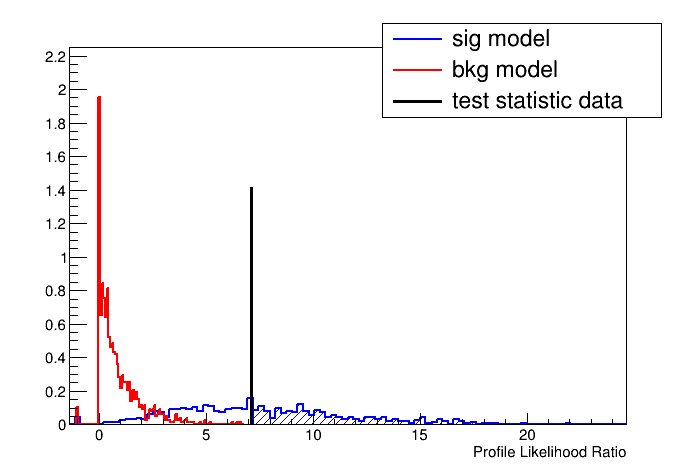

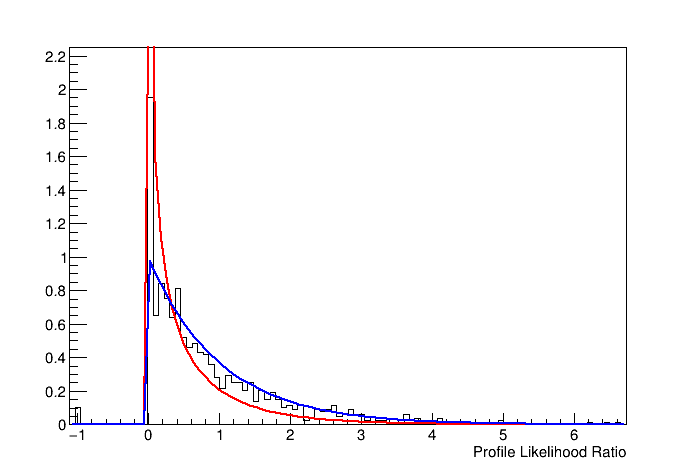

In [7]:
a = ws.var('a')
theta = ws.var('theta')
a.setVal(0)
bkg_model = ROOT.RooStats.ModelConfig('bkg model',ws)
bkg_model.SetPdf(pdf)
bkg_model.SetParametersOfInterest('a,theta')
bkg_model.SetObservables('x')
bkg_model.SetSnapshot(ROOT.RooArgSet(ws.var('a')))

a.setVal(aval)
theta.setVal(thetaval)
sig_model = bkg_model.Clone('sig model')
sig_model.SetPdf(pdf)
sig_model.SetParametersOfInterest('a,theta')
sig_model.SetSnapshot(ROOT.RooArgSet(ws.var('a'),ws.var('theta')))

### Frequentist
hypoCalc = ROOT.RooStats.FrequentistCalculator(roodata,sig_model,bkg_model)
hypoCalc.SetToys(1000,1000) # toys for bkg/alternative

test = ROOT.RooStats.ProfileLikelihoodTestStat(pdf)
test.EnableDetailedOutput(True)

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(test)
toy_sampler.SetNEventsPerToy(ndata)

htr = hypoCalc.GetHypoTest()
#htr.SetPValueIsRightTail(True) # already default
#htr.SetBackgroundAsAlt(False) # already default
htr.Print()

plot = ROOT.RooStats.HypoTestPlot(htr,100)

canvas = ROOT.TCanvas()
plot.Draw()
canvas.Draw()

nullDistr = htr.GetNullDistribution()
plotDistr = ROOT.RooStats.SamplingDistPlot()
plotDistr.AddSamplingDistribution(nullDistr)

c2 = ROOT.TCanvas()
plotDistr.Draw()
minval = plot.GetTH1F(nullDistr).GetXaxis().GetXmin()
maxval = plot.GetTH1F(nullDistr).GetXaxis().GetXmax()

f1 = ROOT.TF1('f','2*ROOT::Math::chisquared_pdf(2*x,1,0)',minval,maxval)
f1.SetLineColor(ROOT.kRed)
f2 = ROOT.TF1('f','2*ROOT::Math::chisquared_pdf(2*x,2,0)',minval,maxval)
f2.SetLineColor(ROOT.kBlue)
f1.Draw('same')
f2.Draw('same')
c2.Draw()

## 2D/1D confidence intervals with the likelihood ratio test

- Here the phase $\theta$ is considered as nuisance parameter and is profiled in the test statistic, i.e. for each value of $a$ an optimal value of $\hat{\hat{\theta}}$ is obtained minimazing the negative log likelihood
\begin{equation}
t = − 2 \log \frac{\mathcal{L}(a , \hat{\hat{\theta}} )}{\mathcal{L}(\hat{a} , \hat{\theta} )}
\end{equation}
- The 2D test statistic is now reduced to 1D and depends only on one parameter $a$

#### Python

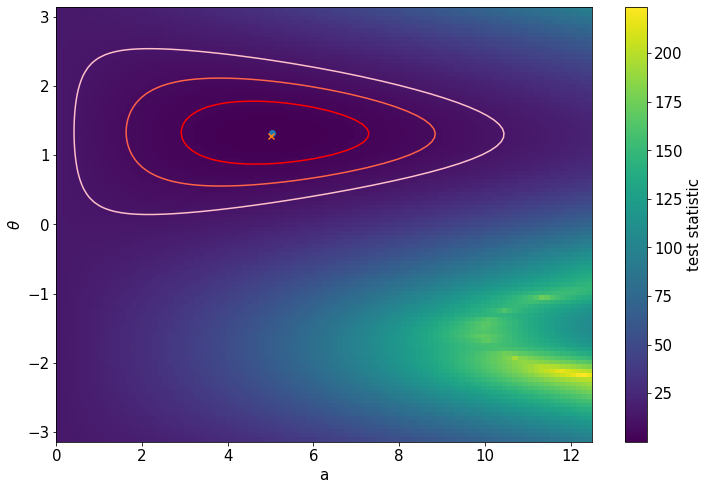

In [8]:
a = np.linspace(0,12.5,101)
theta = np.linspace(-np.pi,np.pi,101)
av,thetav = np.meshgrid(a,theta)
t =-2*(fit_result.fun-nll(data = data, model = model, pars = [av,thetav]))
plt.figure()
plt.hist2d(av.flatten(),thetav.flatten(),weights=t.flatten(),bins=[len(a),len(theta)])
coverage_sigma1 = norm.cdf(1)-norm.cdf(-1)
coverage_sigma2 = norm.cdf(2)-norm.cdf(-2)
coverage_sigma3 = norm.cdf(3)-norm.cdf(-3)
plt.colorbar(label='test statistic')
plt.ylabel(r'$\theta$')
plt.xlabel('a')
t = t.reshape(len(a),len(theta))
plt.contour(a,theta,t,[chi2(2).ppf(coverage_sigma1),chi2(2).ppf(coverage_sigma2),chi2(2).ppf(coverage_sigma3)],colors=['red','tomato','pink'])
plt.scatter(fit_result.x[0],fit_result.x[1])
plt.scatter(aval,thetaval,marker='x')

a = 5.03 +1.48 -1.41


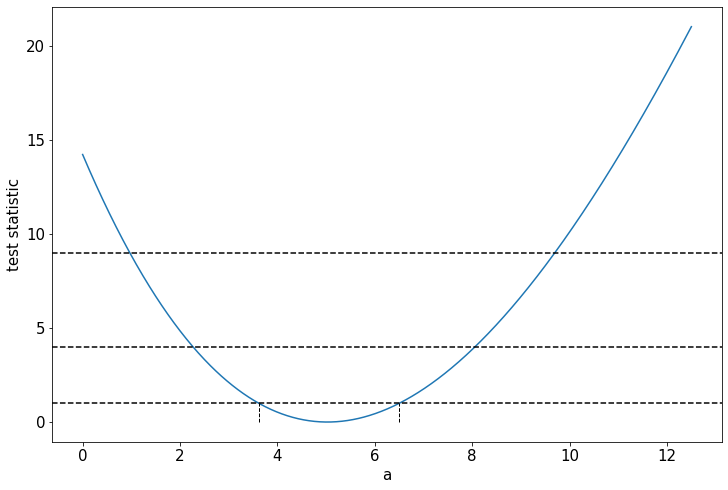

In [9]:
a = np.linspace(0,12.5,1001)
t = []
for ai in a:
    res = minimize(lambda pars: nll(data,model,pars),x0=[ai,thetaval],constraints = ({'type': 'eq', 'fun': lambda pars:  pars[0]-ai}))
    t.append(-2*(fit_result.fun-res.fun))
t = np.array(t)
plt.figure()
plt.xlabel('a')
plt.ylabel('test statistic')
plt.plot(a,t)
plt.axhline(1,color='black',linestyle='dashed')
plt.axhline(4,color='black',linestyle='dashed')
plt.axhline(9,color='black',linestyle='dashed')
da = (a.max()-a.min())/(len(a)-1)
amin = np.min(a[t<1])-da/2.
amax = np.max(a[t<1])+da/2.
print('a = %.2f +%.2f -%.2f'%(fit_result.x[0],amax-fit_result.x[0],fit_result.x[0]-amin))
plt.vlines([amin,amax],0,1,lw=1,color='black',ls='dashed')

#### ROOT - RooStats

a = 5.03 +1.48 -1.41
[#1] INFO:Minimization -- createConstraintTerm picked up cached constraints from workspace with 0 entries
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoGLobalFit - find MLE 
[#0] PROGRESS:Minimization -- ProfileLikelihoodCalcultor::DoMinimizeNLL - using Minuit / Migrad with strategy 1
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization -- 
  RooFitResult: minimized FCN value: 762.375, estimated distance to minimum: 1.12841e-09
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                     a    5.0265e+00 +/-  1.44e+00
                 theta    1.3190e+00 +/-  2.94e-01

[#1] INFO:Minimization -- RooProfileLL::evaluate(nll_pdf_data_Profile[a,theta]) Creating instance of MINUIT
[#1] INFO:Minimization -- RooProfileLL::ev

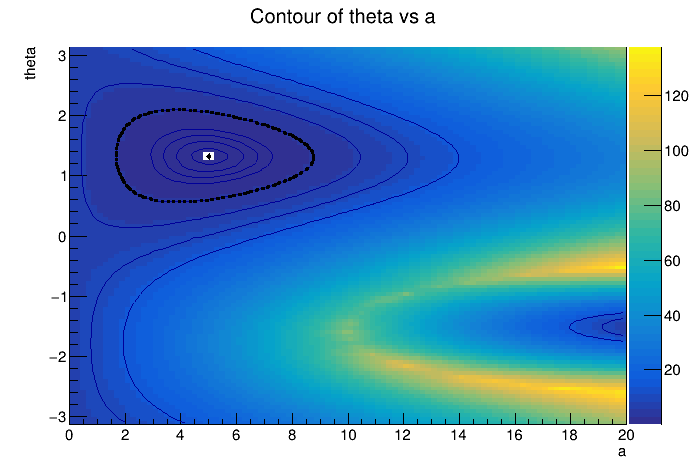

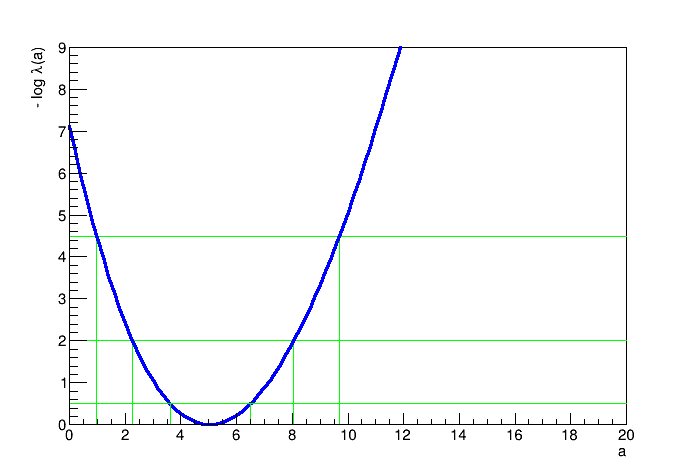

In [10]:
### Profile Likelihood
a = ws.var('a')
theta = ws.var('theta')
paramInterest = ROOT.RooArgSet(a,theta)
pl = ROOT.RooStats.ProfileLikelihoodCalculator(roodata,pdf,paramInterest)

interval = pl.GetInterval()
c3 = ROOT.TCanvas()
intervalplot = ROOT.RooStats.LikelihoodIntervalPlot(interval)
intervalplot.SetNPoints(10000)
intervalplot.Draw('nominuit hist')
c3.Draw()

paramInterest.setRealValue('a',0)
paramInterest.setRealValue('theta',1)
pl.SetNullParameters( paramInterest )
hp = pl.GetHypoTest()
hp.Print()

pl_a = ROOT.RooStats.ProfileLikelihoodCalculator(roodata,pdf,ROOT.RooArgSet(a))
interval_a = pl_a.GetInterval()
from scipy.stats import norm
interval_a.SetConfidenceLevel(norm.cdf(3)-norm.cdf(-3))
c4 = ROOT.TCanvas()
intervalplot_a = ROOT.RooStats.LikelihoodIntervalPlot(interval_a)
intervalplot_a.SetMaximum(9)
intervalplot_a.SetNPoints(100)
intervalplot_a.Draw()

interval_a.SetConfidenceLevel(norm.cdf(2)-norm.cdf(-2))
intervalplot_a.Draw('same')

interval_a.SetConfidenceLevel(norm.cdf(1)-norm.cdf(-1))
intervalplot_a.Draw('same')
interval_a.GetBestFitParameters().Print('v')
best_a = interval_a.GetBestFitParameters().find('a')
print('a = %.2f +%.2f -%.2f'%(best_a.getVal(),interval_a.UpperLimit(best_a)-best_a.getVal(),best_a.getVal()-interval_a.LowerLimit(best_a)))
c4.Draw()